<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/notebooks/2020_0515komazawa_visualize_layers_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 意味ある摂動によるブラックボックスの解釈可能な説明
### Interpretable Explanations of Black Boxes by Meaningful Perturbation

- filename: 2020_0515komazawa_visualize_layers_demo.ipynb

<center>
<img src="2018Fong_Black_Box_fig1.svg" width="49%">
    
図 1．画像をぼかして学習したマスク (右)，そのターゲットクラスのソフトマックス確率を抑制した例　(左: 元画像，画像上のソフトマックス得点)。   
<!-- Figure 1. An example of a mask learned (right) by blurring an image (middle) to suppress the softmax probability of its target class (left: original image; softmax scores above images). -->
  
</center>

In [5]:
import IPython
isColab = 'google.colab' in str(IPython.get_ipython())

In [6]:
# source: /Users/asakawa/study/2020jacobgil_pytorch-explain-black-box.git/explain.py
# title: PyTorch implementation of Interpretable Explanations of Black Boxes by Meaningful Perturbation
# paper:  https://arxiv.org/abs/1704.03296
import torch
from torch.autograd import Variable
from torchvision import models
import cv2
import sys
import numpy as np

原著論文 5 頁より

## 4.2 削除と保存
<!-- ## 4.2 Deletion and preservation -->

画像 $x_0$ が与えられたとき，ブラックボックスの振る舞いを説明するために，画像領域の削除の効果をコンパクトにまとめることが目標である。
この問題に対する一つのアプローチは，最大限の情報量を持つ削除領域を見つけることである。
<!-- Given an image $x_0$, our goal is to summarize compactly the effect of deleting image regions in order to explain the behavior of the black box. 
One approach to this problem is to find deletion regions that are maximally informative. -->

議論を簡単にするために，ここでの残りの部分では，ブラックボックス $f(x) \in\mathbb{R}^C$
は，画像の内容に関する異なる仮説に対する得点ベクトルを生成する (例えば，ニューラルネットワークのソフトマックス確率層として) ブラックボックスを考える。
そして，$c$ を対象クラスとし，得点  $f_c(\Phi(x_0; m)) \ll f_c(x_0)$ を大きく低下させる最小の削除マスク $m$ を求める「削除ゲーム」を考察する。
$m$ を見つけることは，次のような学習問題として定式化できる。
<!-- In order to simplify the discussion, in the rest of the paper we consider black boxes $f(x)\in\mathbb{R}^C$
that generate a vector of scores for different hypotheses about the content of the image (e.g. as a softmax probability layer in a neural  network). 
Then, we consider a “deletion game” where the goal is to find the smallest deletion mask $m$ that causes the score $f_c(\Phi(x_0; m)) \ll f_c(x_0)$ to drop significantly, where $c$ is the target class. 
Finding $m$ can be formulated as the following learning problem: -->

$$
m^*=\arg\min_{m\in[0,1]^\Lambda} \lambda\left\|1-m\right\|_1 + f_c(\Phi(x_0;m)) \hspace{5em}(3)
$$

ここで $\lambda$ はマスクの大部分をオフにするように促す (したがって，$x_0$ の小さな下位集合を削除する)。
このようにして，ネットワークの情報量が多い領域を見つけることができる。
<!-- where $\lambda$ encourages most of the mask to be turned off (hence deleting a small subset of $x_0$). 
In this manner, we can find a highly informative region for the network. -->

また，対称的な ｢保存ゲーム preservation game｣ を行うこともできる。
このゲームの目的は，得点 $f_c(\Phi(x_0; m))\ge f_c(x_0): m^*=\arg\min_{m}\lambda \left\|m\right\|_1 − f_c(\Phi(x_0; m))$ を維持するための最小の画像のサブセットを見つけることである。
削除ゲームではネットワークが画像中の物体を認識できない程度の証拠を削除するのに対し，保存ゲームでは十分な証拠の最小部分集合を求める点が大きく異なる。
<!-- One can also play an symmetric “preservation game”, where the goal is to find the smallest subset of the image that must be retained to preserve the score $f_c(\Phi(x_0; m))\ge f_c(x_0): m^*=\arg\min_{m}\lambda \left\|m\right\|_1 − f_c(\Phi(x_0; m))$. 
The main difference is that the deletion game removes enough evidence to prevent the network from recognizing the object in the image, whereas the preservation game finds a minimal subset of sufficient evidence. -->

### 反復勾配 
<!-- ### Iterated gradients. -->
どちらの最適化問題も，勾配降下法による局所探索を用いて解く。
このように，本手法は [15] のアプローチと同様に，ブラックボックス $f$ の勾配を計算することによって情報を抽出する。
しかし，この方法は，数回の勾配評価により漸進的に情報を抽出し，時間とともにますます多くの情報を蓄積する点で異なっている。
<!-- Both optimization problems are solved by using a local search by means of gradient descent methods. 
In this manner, our method extracts information from the black box f by computing its gradient, similar to the approach of [15]. 
However, it differs in that it extracts this information progressively, over several gradient evaluations, accumulating increasingly more information over time. -->

## 4.3. アーチファクトへの対処
<!-- ## 4.3. Dealing with artifacts-->
単一の代表的な摂動を見つけることにコミットすることによって，我々のアプローチはブラックボックスのアーチファクトをトリガーするリスクを負うことになる。
特にニューラルネットワークは，驚くべきアーチファクトの影響を受けることが知られている [5, 10, 7]。これらの研究は，ニューラルネットワークが無意味な出力や予想外の出力を生成するような特定の入力を見つけることが可能であることを実証している。
ニューラルネットワークは自然な画像統計に基づいて識別的に学習されるため，これは全く驚くべきことではない。
すべてのアーチファクトが「不自然」に見えるわけではないが，それでも，ネットワークが正常に動作しているときには無視できるほどの確率でサンプリングされる画像の下位集合を形成していることは確かである。
<!-- By committing to finding a single representative perturbation, our approach incurs the risk of triggering artifacts of the black box. 
Neural networks, in particular, are known to be affected by surprising artifacts [5, 10, 7]; these works demonstrate that it is possible to find particular inputs that can drive the neural network to generate nonsensical or unexpected outputs. 
This is not entirely surprising since neural networks are trained discriminatively on natural image statistics. 
While not all artifacts look “unnatural”, nevertheless they form a subset of images that is sampled with negligible probability when the network is operated normally. -->

アーチファクトの存在とその特徴付けはそれ自体興味深い問題であるが，我々は通常の動作条件下でのブラックボックスの挙動を特徴付けたいと考えている。
残念ながら，図 5 に示すように，式 (3) のような目的関数はそのようなアーティファクトに強く引き付けられ，アーチファクトを誘発する微妙に構造化された削除マスクを素朴に学習してしまう。
特に，雑音や定常的な摂動は，鋭い色コントラストを利用して，ぼかしよりも簡単にアーティファクトを作り出すことができるためでる (図 5 下段)。
<!-- Although the existence and characterization of artifacts is an interesting problem per se, we wish to characterize the behavior of black boxes under normal operating conditions. 
Unfortunately, as illustrated in fig. 5, objectives such as eq. (3) are strongly attracted by such artifacts, and naively learn subtly-structured deletion masks that trigger them. 
This is particularly true for the noise and constant perturbations as they can more easily than blur create artifacts using sharp color contrasts (fig. 5, bottom row).-->

<center>
<img src="2018Fong_Black_Box_fig5.svg" width="66%">
<div style="width:77%;text-align:left; background-color:silkblue">

図 5. 
左から右へ：GoogLeNet [17] によって大きな信頼性をもって正しく分類された画像。
正しく認識されなくなった画像。
アーティファクトで学習した削除マスク。
<!-- Figure 5. 
From left to right: an image correctly classified with large confidence by GoogLeNet [17]; 
a perturbed image that is not recognized correctly anymore; 
the deletion mask learned with artifacts.  -->
上: 定数，ランダム雑音，ぼかしの摂動を共同で適用し，予測された上位 5 つのクラスを最小化することによって学習されたマスク。
このマスクは，カップの縁に沿って高度に構造化された渦巻きを追加するように学習していることに注意$(\gamma=1; \lambda_1=10^{-5};\lambda_2=10^{-3};\beta= 3)$。
下: 一定の摂動を与えて学習した最小化 top5 マスク。
このマスクは，ポールを削除する代わりに，空にシャープで不自然なアーティファクトを導入するように学習することに注目。$(\gamma=0.1;\lambda_1=10^{-4};\lambda_2=10^{-2};\beta=3)$。
<!-- Top: A mask learned by minimizing the top five predicted classes by jointly applying the constant, random noise, and blur perturbations. 
Note that the mask learns to add highly structured swirls along the rim of the cup (gamma=1; lamba_1=10^{-5};lambda_2=10^{-3};beta= 3). 
Bottom: A minimizing-top5 mask learned by applying a constant perturbation. 
Notice that the mask learns to introduce sharp, unnatural artifacts in the sky instead of deleting the pole (gamma=0.1;lambda_1=10^{-4};lambda_2=10^{-2};beta=3). -->
</div>
</center>

我々は，説明文の生成時にこのようなアーチファクトを回避するために，2 つのアプローチを提案する。
一つは，強力な説明文は他の予測因子と同様に，可能な限り一般化すべきであるということである。
削除ゲームでは，これは単一に学習されたマスク $m$ の詳細に依存しないことを意味する。
そこで，マスク $m$ を確率的に，小さなランダムジッターまで適用するように問題を再定式化する。
<!-- We suggests two approaches to avoid such artifacts in generating explanations. 
The first one is that powerful explanations should, just like any predictor, generalize as much as possible. 
For the deletion game, this means not relying on the details of a singly-learned mask m. 
Hence, we reformulate the problem to apply the mask $m$ stochastically, up to small random jitter. -->

第二に、我々はネットワーク・アーティファクトと協調したマスクは **自然の摂動を代表するものではない**  と主張する。
前述したように，説明の意味は入力 $x$ に加えられた変化の意味に依存する。
自然な摂動をより代表するマスクを得るために，アーティファクトと協調できない単純で規則的な構造を持つように促すことができる。
我々は，$m$ を全変動 (TV) ノルムで正則化し，低解像度バージョンからアップサンプリングすることでこれを実現する。
<!-- Second, we argue that masks co-adapted with network artifacts are _not representative of natural perturbations_. 
As noted before, the meaning of an explanation depends on the meaning of the changes applied to the input $x$; to obtain a mask more representative of natural perturbations we can encourage it to have a simple, regular structure which cannot be co-adapted to artifacts. We do so by regularizing $m$ in total-variation (TV) norm and upsampling it from a low resolution version.
-->

この2つの修正により、式(3)は次のようになる。
<!-- With these two modifications, eq. (3) becomes: -->

$$
\min_{m\in[0,1]^\Lambda}=\lambda_1\left\|1-m\right\|_1 + \lambda_2\left\|\nabla m(u)\right\|_\beta^\beta +\mathbb{E}_r\left[f_c(\Phi(x_0(\cdot-\tau),m))\right], \hspace{5em}(4)
$$

ここで $M(v) = \sum_u g_{\sigma_m}(v/s-u)m(u)$ はアップサンプルマスク，$g_{\sigma_m}$ は 2 次元ガウスカーネルである。
式 (4) は確率的勾配降下法を用いて最適化することができる。
<!-- where $M(v) = \sum_u g_{\sigma_m}(v/s-u)m(u)$ is the upsampled mask and $g_{\sigma_m}$ is a 2D Gaussian kernel. 
Equation (4) can be optimized using stochastic gradient descent.
 -->

In [7]:
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

In [13]:
def tv_norm(input, tv_beta):
    img = input[0, 0, :]
    row_grad = torch.mean(torch.abs((img[:-1 , :] - img[1 :, :])).pow(tv_beta))
    col_grad = torch.mean(torch.abs((img[: , :-1] - img[: , 1 :])).pow(tv_beta))
    return row_grad + col_grad

def preprocess_image(img):
    means=[0.485, 0.456, 0.406]
    stds=[0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[: , :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
        
    preprocessed_img = np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))

    if use_cuda:
        preprocessed_img_tensor = torch.from_numpy(preprocessed_img).cuda()
    else:
        preprocessed_img_tensor = torch.from_numpy(preprocessed_img)
        
    preprocessed_img_tensor.unsqueeze_(0)
    return Variable(preprocessed_img_tensor, requires_grad = False)


def save(mask, img, blurred):
    mask = mask.cpu().data.numpy()[0]
    mask = np.transpose(mask, (1, 2, 0))
    
    mask = (mask - np.min(mask)) / np.max(mask)
    mask = 1 - mask
    heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
    
    heatmap = np.float32(heatmap) / 255
    cam = 1.0*heatmap + np.float32(img)/255
    cam = cam / np.max(cam)
    
    img = np.float32(img) / 255
    perturbated = np.multiply(1 - mask, img) + np.multiply(mask, blurred)   
    
    cv2.imwrite("perturbated.png", np.uint8(255 * perturbated))
    cv2.imwrite("heatmap.png", np.uint8(255 * heatmap))
    cv2.imwrite("mask.png", np.uint8(255 * mask))
    cv2.imwrite("cam.png", np.uint8(255 * cam))


def numpy_to_torch(img, requires_grad = True):
    if len(img.shape) < 3:
        output = np.float32([img])
    else:
        output = np.transpose(img, (2, 0, 1))

    output = torch.from_numpy(output)
    if use_cuda:
        output = output.cuda()

    output.unsqueeze_(0)
    v = Variable(output, requires_grad = requires_grad)
    return v


def load_model():
    model = models.vgg19(weights="DEFAULT", progress=True)
    model.eval()
    if use_cuda:
        model.cuda()
        
    for p in model.features.parameters():
        p.requires_grad = False
    for p in model.classifier.parameters():
        p.requires_grad = False

    return model

In [11]:
if isColab:
    # 自分の PC に入っている画像を試してみましょう
    from google.colab import files
    uploaded = files.upload()

In [45]:
# URL が変更になっているようなので，自前で解決するように変更した 
# date: 2021-04-16
#import requests
#
#LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
#
# download the imagenet category list
#classes = {int(key):value for (key, value)
#          in requests.get(LABELS_URL).json().items()}

labelmeta = {"n02119789": ["kit fox", "Vulpes macrotis"], "n02100735": ["English setter"], "n02110185": ["Siberian husky"], "n02096294": ["Australian terrier"], "n02102040": ["English springer", "English springer spaniel"], "n02066245": ["grey whale", "gray whale", "devilfish", "Eschrichtius gibbosus", "Eschrichtius robustus"], "n02509815": ["lesser panda", "red panda", "panda", "bear cat", "cat bear", "Ailurus fulgens"], "n02124075": ["Egyptian cat"], "n02417914": ["ibex", "Capra ibex"], "n02123394": ["Persian cat"], "n02125311": ["cougar", "puma", "catamount", "mountain lion", "painter", "panther", "Felis concolor"], "n02423022": ["gazelle"], "n02346627": ["porcupine", "hedgehog"], "n02077923": ["sea lion"], "n02110063": ["malamute", "malemute", "Alaskan malamute"], "n02447366": ["badger"], "n02109047": ["Great Dane"], "n02089867": ["Walker hound", "Walker foxhound"], "n02102177": ["Welsh springer spaniel"], "n02091134": ["whippet"], "n02092002": ["Scottish deerhound", "deerhound"], "n02071294": ["killer whale", "killer", "orca", "grampus", "sea wolf", "Orcinus orca"], "n02442845": ["mink"], "n02504458": ["African elephant", "Loxodonta africana"], "n02092339": ["Weimaraner"], "n02098105": ["soft-coated wheaten terrier"], "n02096437": ["Dandie Dinmont", "Dandie Dinmont terrier"], "n02114712": ["red wolf", "maned wolf", "Canis rufus", "Canis niger"], "n02105641": ["Old English sheepdog", "bobtail"], "n02128925": ["jaguar", "panther", "Panthera onca", "Felis onca"], "n02091635": ["otterhound", "otter hound"], "n02088466": ["bloodhound", "sleuthhound"], "n02096051": ["Airedale", "Airedale terrier"], "n02117135": ["hyena", "hyaena"], "n02138441": ["meerkat", "mierkat"], "n02097130": ["giant schnauzer"], "n02493509": ["titi", "titi monkey"], "n02457408": ["three-toed sloth", "ai", "Bradypus tridactylus"], "n02389026": ["sorrel"], "n02443484": ["black-footed ferret", "ferret", "Mustela nigripes"], "n02110341": ["dalmatian", "coach dog", "carriage dog"], "n02089078": ["black-and-tan coonhound"], "n02086910": ["papillon"], "n02445715": ["skunk", "polecat", "wood pussy"], "n02093256": ["Staffordshire bullterrier", "Staffordshire bull terrier"], "n02113978": ["Mexican hairless"], "n02106382": ["Bouvier des Flandres", "Bouviers des Flandres"], "n02441942": ["weasel"], "n02113712": ["miniature poodle"], "n02113186": ["Cardigan", "Cardigan Welsh corgi"], "n02105162": ["malinois"], "n02415577": ["bighorn", "bighorn sheep", "cimarron", "Rocky Mountain bighorn", "Rocky Mountain sheep", "Ovis canadensis"], "n02356798": ["fox squirrel", "eastern fox squirrel", "Sciurus niger"], "n02488702": ["colobus", "colobus monkey"], "n02123159": ["tiger cat"], "n02098413": ["Lhasa", "Lhasa apso"], "n02422699": ["impala", "Aepyceros melampus"], "n02114855": ["coyote", "prairie wolf", "brush wolf", "Canis latrans"], "n02094433": ["Yorkshire terrier"], "n02111277": ["Newfoundland", "Newfoundland dog"], "n02132136": ["brown bear", "bruin", "Ursus arctos"], "n02119022": ["red fox", "Vulpes vulpes"], "n02091467": ["Norwegian elkhound", "elkhound"], "n02106550": ["Rottweiler"], "n02422106": ["hartebeest"], "n02091831": ["Saluki", "gazelle hound"], "n02120505": ["grey fox", "gray fox", "Urocyon cinereoargenteus"], "n02104365": ["schipperke"], "n02086079": ["Pekinese", "Pekingese", "Peke"], "n02112706": ["Brabancon griffon"], "n02098286": ["West Highland white terrier"], "n02095889": ["Sealyham terrier", "Sealyham"], "n02484975": ["guenon", "guenon monkey"], "n02137549": ["mongoose"], "n02500267": ["indri", "indris", "Indri indri", "Indri brevicaudatus"], "n02129604": ["tiger", "Panthera tigris"], "n02090721": ["Irish wolfhound"], "n02396427": ["wild boar", "boar", "Sus scrofa"], "n02108000": ["EntleBucher"], "n02391049": ["zebra"], "n02412080": ["ram", "tup"], "n02108915": ["French bulldog"], "n02480495": ["orangutan", "orang", "orangutang", "Pongo pygmaeus"], "n02110806": ["basenji"], "n02128385": ["leopard", "Panthera pardus"], "n02107683": ["Bernese mountain dog"], "n02085936": ["Maltese dog", "Maltese terrier", "Maltese"], "n02094114": ["Norfolk terrier"], "n02087046": ["toy terrier"], "n02100583": ["vizsla", "Hungarian pointer"], "n02096177": ["cairn", "cairn terrier"], "n02494079": ["squirrel monkey", "Saimiri sciureus"], "n02105056": ["groenendael"], "n02101556": ["clumber", "clumber spaniel"], "n02123597": ["Siamese cat", "Siamese"], "n02481823": ["chimpanzee", "chimp", "Pan troglodytes"], "n02105505": ["komondor"], "n02088094": ["Afghan hound", "Afghan"], "n02085782": ["Japanese spaniel"], "n02489166": ["proboscis monkey", "Nasalis larvatus"], "n02364673": ["guinea pig", "Cavia cobaya"], "n02114548": ["white wolf", "Arctic wolf", "Canis lupus tundrarum"], "n02134084": ["ice bear", "polar bear", "Ursus Maritimus", "Thalarctos maritimus"], "n02480855": ["gorilla", "Gorilla gorilla"], "n02090622": ["borzoi", "Russian wolfhound"], "n02113624": ["toy poodle"], "n02093859": ["Kerry blue terrier"], "n02403003": ["ox"], "n02097298": ["Scotch terrier", "Scottish terrier", "Scottie"], "n02108551": ["Tibetan mastiff"], "n02493793": ["spider monkey", "Ateles geoffroyi"], "n02107142": ["Doberman", "Doberman pinscher"], "n02096585": ["Boston bull", "Boston terrier"], "n02107574": ["Greater Swiss Mountain dog"], "n02107908": ["Appenzeller"], "n02086240": ["Shih-Tzu"], "n02102973": ["Irish water spaniel"], "n02112018": ["Pomeranian"], "n02093647": ["Bedlington terrier"], "n02397096": ["warthog"], "n02437312": ["Arabian camel", "dromedary", "Camelus dromedarius"], "n02483708": ["siamang", "Hylobates syndactylus", "Symphalangus syndactylus"], "n02097047": ["miniature schnauzer"], "n02106030": ["collie"], "n02099601": ["golden retriever"], "n02093991": ["Irish terrier"], "n02110627": ["affenpinscher", "monkey pinscher", "monkey dog"], "n02106166": ["Border collie"], "n02326432": ["hare"], "n02108089": ["boxer"], "n02097658": ["silky terrier", "Sydney silky"], "n02088364": ["beagle"], "n02111129": ["Leonberg"], "n02100236": ["German short-haired pointer"], "n02486261": ["patas", "hussar monkey", "Erythrocebus patas"], "n02115913": ["dhole", "Cuon alpinus"], "n02486410": ["baboon"], "n02487347": ["macaque"], "n02099849": ["Chesapeake Bay retriever"], "n02108422": ["bull mastiff"], "n02104029": ["kuvasz"], "n02492035": ["capuchin", "ringtail", "Cebus capucinus"], "n02110958": ["pug", "pug-dog"], "n02099429": ["curly-coated retriever"], "n02094258": ["Norwich terrier"], "n02099267": ["flat-coated retriever"], "n02395406": ["hog", "pig", "grunter", "squealer", "Sus scrofa"], "n02112350": ["keeshond"], "n02109961": ["Eskimo dog", "husky"], "n02101388": ["Brittany spaniel"], "n02113799": ["standard poodle"], "n02095570": ["Lakeland terrier"], "n02128757": ["snow leopard", "ounce", "Panthera uncia"], "n02101006": ["Gordon setter"], "n02115641": ["dingo", "warrigal", "warragal", "Canis dingo"], "n02097209": ["standard schnauzer"], "n02342885": ["hamster"], "n02097474": ["Tibetan terrier", "chrysanthemum dog"], "n02120079": ["Arctic fox", "white fox", "Alopex lagopus"], "n02095314": ["wire-haired fox terrier"], "n02088238": ["basset", "basset hound"], "n02408429": ["water buffalo", "water ox", "Asiatic buffalo", "Bubalus bubalis"], "n02133161": ["American black bear", "black bear", "Ursus americanus", "Euarctos americanus"], "n02328150": ["Angora", "Angora rabbit"], "n02410509": ["bison"], "n02492660": ["howler monkey", "howler"], "n02398521": ["hippopotamus", "hippo", "river horse", "Hippopotamus amphibius"], "n02112137": ["chow", "chow chow"], "n02510455": ["giant panda", "panda", "panda bear", "coon bear", "Ailuropoda melanoleuca"], "n02093428": ["American Staffordshire terrier", "Staffordshire terrier", "American pit bull terrier", "pit bull terrier"], "n02105855": ["Shetland sheepdog", "Shetland sheep dog", "Shetland"], "n02111500": ["Great Pyrenees"], "n02085620": ["Chihuahua"], "n02123045": ["tabby", "tabby cat"], "n02490219": ["marmoset"], "n02099712": ["Labrador retriever"], "n02109525": ["Saint Bernard", "St Bernard"], "n02454379": ["armadillo"], "n02111889": ["Samoyed", "Samoyede"], "n02088632": ["bluetick"], "n02090379": ["redbone"], "n02443114": ["polecat", "fitch", "foulmart", "foumart", "Mustela putorius"], "n02361337": ["marmot"], "n02105412": ["kelpie"], "n02483362": ["gibbon", "Hylobates lar"], "n02437616": ["llama"], "n02107312": ["miniature pinscher"], "n02325366": ["wood rabbit", "cottontail", "cottontail rabbit"], "n02091032": ["Italian greyhound"], "n02129165": ["lion", "king of beasts", "Panthera leo"], "n02102318": ["cocker spaniel", "English cocker spaniel", "cocker"], "n02100877": ["Irish setter", "red setter"], "n02074367": ["dugong", "Dugong dugon"], "n02504013": ["Indian elephant", "Elephas maximus"], "n02363005": ["beaver"], "n02102480": ["Sussex spaniel"], "n02113023": ["Pembroke", "Pembroke Welsh corgi"], "n02086646": ["Blenheim spaniel"], "n02497673": ["Madagascar cat", "ring-tailed lemur", "Lemur catta"], "n02087394": ["Rhodesian ridgeback"], "n02127052": ["lynx", "catamount"], "n02116738": ["African hunting dog", "hyena dog", "Cape hunting dog", "Lycaon pictus"], "n02488291": ["langur"], "n02091244": ["Ibizan hound", "Ibizan Podenco"], "n02114367": ["timber wolf", "grey wolf", "gray wolf", "Canis lupus"], "n02130308": ["cheetah", "chetah", "Acinonyx jubatus"], "n02089973": ["English foxhound"], "n02105251": ["briard"], "n02134418": ["sloth bear", "Melursus ursinus", "Ursus ursinus"], "n02093754": ["Border terrier"], "n02106662": ["German shepherd", "German shepherd dog", "German police dog", "alsatian"], "n02444819": ["otter"], "n01882714": ["koala", "koala bear", "kangaroo bear", "native bear", "Phascolarctos cinereus"], "n01871265": ["tusker"], "n01872401": ["echidna", "spiny anteater", "anteater"], "n01877812": ["wallaby", "brush kangaroo"], "n01873310": ["platypus", "duckbill", "duckbilled platypus", "duck-billed platypus", "Ornithorhynchus anatinus"], "n01883070": ["wombat"], "n04086273": ["revolver", "six-gun", "six-shooter"], "n04507155": ["umbrella"], "n04147183": ["schooner"], "n04254680": ["soccer ball"], "n02672831": ["accordion", "piano accordion", "squeeze box"], "n02219486": ["ant", "emmet", "pismire"], "n02317335": ["starfish", "sea star"], "n01968897": ["chambered nautilus", "pearly nautilus", "nautilus"], "n03452741": ["grand piano", "grand"], "n03642806": ["laptop", "laptop computer"], "n07745940": ["strawberry"], "n02690373": ["airliner"], "n04552348": ["warplane", "military plane"], "n02692877": ["airship", "dirigible"], "n02782093": ["balloon"], "n04266014": ["space shuttle"], "n03344393": ["fireboat"], "n03447447": ["gondola"], "n04273569": ["speedboat"], "n03662601": ["lifeboat"], "n02951358": ["canoe"], "n04612504": ["yawl"], "n02981792": ["catamaran"], "n04483307": ["trimaran"], "n03095699": ["container ship", "containership", "container vessel"], "n03673027": ["liner", "ocean liner"], "n03947888": ["pirate", "pirate ship"], "n02687172": ["aircraft carrier", "carrier", "flattop", "attack aircraft carrier"], "n04347754": ["submarine", "pigboat", "sub", "U-boat"], "n04606251": ["wreck"], "n03478589": ["half track"], "n04389033": ["tank", "army tank", "armored combat vehicle", "armoured combat vehicle"], "n03773504": ["missile"], "n02860847": ["bobsled", "bobsleigh", "bob"], "n03218198": ["dogsled", "dog sled", "dog sleigh"], "n02835271": ["bicycle-built-for-two", "tandem bicycle", "tandem"], "n03792782": ["mountain bike", "all-terrain bike", "off-roader"], "n03393912": ["freight car"], "n03895866": ["passenger car", "coach", "carriage"], "n02797295": ["barrow", "garden cart", "lawn cart", "wheelbarrow"], "n04204347": ["shopping cart"], "n03791053": ["motor scooter", "scooter"], "n03384352": ["forklift"], "n03272562": ["electric locomotive"], "n04310018": ["steam locomotive"], "n02704792": ["amphibian", "amphibious vehicle"], "n02701002": ["ambulance"], "n02814533": ["beach wagon", "station wagon", "wagon", "estate car", "beach waggon", "station waggon", "waggon"], "n02930766": ["cab", "hack", "taxi", "taxicab"], "n03100240": ["convertible"], "n03594945": ["jeep", "landrover"], "n03670208": ["limousine", "limo"], "n03770679": ["minivan"], "n03777568": ["Model T"], "n04037443": ["racer", "race car", "racing car"], "n04285008": ["sports car", "sport car"], "n03444034": ["go-kart"], "n03445924": ["golfcart", "golf cart"], "n03785016": ["moped"], "n04252225": ["snowplow", "snowplough"], "n03345487": ["fire engine", "fire truck"], "n03417042": ["garbage truck", "dustcart"], "n03930630": ["pickup", "pickup truck"], "n04461696": ["tow truck", "tow car", "wrecker"], "n04467665": ["trailer truck", "tractor trailer", "trucking rig", "rig", "articulated lorry", "semi"], "n03796401": ["moving van"], "n03977966": ["police van", "police wagon", "paddy wagon", "patrol wagon", "wagon", "black Maria"], "n04065272": ["recreational vehicle", "RV", "R.V."], "n04335435": ["streetcar", "tram", "tramcar", "trolley", "trolley car"], "n04252077": ["snowmobile"], "n04465501": ["tractor"], "n03776460": ["mobile home", "manufactured home"], "n04482393": ["tricycle", "trike", "velocipede"], "n04509417": ["unicycle", "monocycle"], "n03538406": ["horse cart", "horse-cart"], "n03599486": ["jinrikisha", "ricksha", "rickshaw"], "n03868242": ["oxcart"], "n02804414": ["bassinet"], "n03125729": ["cradle"], "n03131574": ["crib", "cot"], "n03388549": ["four-poster"], "n02870880": ["bookcase"], "n03018349": ["china cabinet", "china closet"], "n03742115": ["medicine chest", "medicine cabinet"], "n03016953": ["chiffonier", "commode"], "n04380533": ["table lamp"], "n03337140": ["file", "file cabinet", "filing cabinet"], "n03891251": ["park bench"], "n02791124": ["barber chair"], "n04429376": ["throne"], "n03376595": ["folding chair"], "n04099969": ["rocking chair", "rocker"], "n04344873": ["studio couch", "day bed"], "n04447861": ["toilet seat"], "n03179701": ["desk"], "n03982430": ["pool table", "billiard table", "snooker table"], "n03201208": ["dining table", "board"], "n03290653": ["entertainment center"], "n04550184": ["wardrobe", "closet", "press"], "n07742313": ["Granny Smith"], "n07747607": ["orange"], "n07749582": ["lemon"], "n07753113": ["fig"], "n07753275": ["pineapple", "ananas"], "n07753592": ["banana"], "n07754684": ["jackfruit", "jak", "jack"], "n07760859": ["custard apple"], "n07768694": ["pomegranate"], "n12267677": ["acorn"], "n12620546": ["hip", "rose hip", "rosehip"], "n13133613": ["ear", "spike", "capitulum"], "n11879895": ["rapeseed"], "n12144580": ["corn"], "n12768682": ["buckeye", "horse chestnut", "conker"], "n03854065": ["organ", "pipe organ"], "n04515003": ["upright", "upright piano"], "n03017168": ["chime", "bell", "gong"], "n03249569": ["drum", "membranophone", "tympan"], "n03447721": ["gong", "tam-tam"], "n03720891": ["maraca"], "n03721384": ["marimba", "xylophone"], "n04311174": ["steel drum"], "n02787622": ["banjo"], "n02992211": ["cello", "violoncello"], "n04536866": ["violin", "fiddle"], "n03495258": ["harp"], "n02676566": ["acoustic guitar"], "n03272010": ["electric guitar"], "n03110669": ["cornet", "horn", "trumpet", "trump"], "n03394916": ["French horn", "horn"], "n04487394": ["trombone"], "n03494278": ["harmonica", "mouth organ", "harp", "mouth harp"], "n03840681": ["ocarina", "sweet potato"], "n03884397": ["panpipe", "pandean pipe", "syrinx"], "n02804610": ["bassoon"], "n03838899": ["oboe", "hautboy", "hautbois"], "n04141076": ["sax", "saxophone"], "n03372029": ["flute", "transverse flute"], "n11939491": ["daisy"], "n12057211": ["yellow lady\'s slipper", "yellow lady-slipper", "Cypripedium calceolus", "Cypripedium parviflorum"], "n09246464": ["cliff", "drop", "drop-off"], "n09468604": ["valley", "vale"], "n09193705": ["alp"], "n09472597": ["volcano"], "n09399592": ["promontory", "headland", "head", "foreland"], "n09421951": ["sandbar", "sand bar"], "n09256479": ["coral reef"], "n09332890": ["lakeside", "lakeshore"], "n09428293": ["seashore", "coast", "seacoast", "sea-coast"], "n09288635": ["geyser"], "n03498962": ["hatchet"], "n03041632": ["cleaver", "meat cleaver", "chopper"], "n03658185": ["letter opener", "paper knife", "paperknife"], "n03954731": ["plane", "carpenter\'s plane", "woodworking plane"], "n03995372": ["power drill"], "n03649909": ["lawn mower", "mower"], "n03481172": ["hammer"], "n03109150": ["corkscrew", "bottle screw"], "n02951585": ["can opener", "tin opener"], "n03970156": ["plunger", "plumber\'s helper"], "n04154565": ["screwdriver"], "n04208210": ["shovel"], "n03967562": ["plow", "plough"], "n03000684": ["chain saw", "chainsaw"], "n01514668": ["cock"], "n01514859": ["hen"], "n01518878": ["ostrich", "Struthio camelus"], "n01530575": ["brambling", "Fringilla montifringilla"], "n01531178": ["goldfinch", "Carduelis carduelis"], "n01532829": ["house finch", "linnet", "Carpodacus mexicanus"], "n01534433": ["junco", "snowbird"], "n01537544": ["indigo bunting", "indigo finch", "indigo bird", "Passerina cyanea"], "n01558993": ["robin", "American robin", "Turdus migratorius"], "n01560419": ["bulbul"], "n01580077": ["jay"], "n01582220": ["magpie"], "n01592084": ["chickadee"], "n01601694": ["water ouzel", "dipper"], "n01608432": ["kite"], "n01614925": ["bald eagle", "American eagle", "Haliaeetus leucocephalus"], "n01616318": ["vulture"], "n01622779": ["great grey owl", "great gray owl", "Strix nebulosa"], "n01795545": ["black grouse"], "n01796340": ["ptarmigan"], "n01797886": ["ruffed grouse", "partridge", "Bonasa umbellus"], "n01798484": ["prairie chicken", "prairie grouse", "prairie fowl"], "n01806143": ["peacock"], "n01806567": ["quail"], "n01807496": ["partridge"], "n01817953": ["African grey", "African gray", "Psittacus erithacus"], "n01818515": ["macaw"], "n01819313": ["sulphur-crested cockatoo", "Kakatoe galerita", "Cacatua galerita"], "n01820546": ["lorikeet"], "n01824575": ["coucal"], "n01828970": ["bee eater"], "n01829413": ["hornbill"], "n01833805": ["hummingbird"], "n01843065": ["jacamar"], "n01843383": ["toucan"], "n01847000": ["drake"], "n01855032": ["red-breasted merganser", "Mergus serrator"], "n01855672": ["goose"], "n01860187": ["black swan", "Cygnus atratus"], "n02002556": ["white stork", "Ciconia ciconia"], "n02002724": ["black stork", "Ciconia nigra"], "n02006656": ["spoonbill"], "n02007558": ["flamingo"], "n02009912": ["American egret", "great white heron", "Egretta albus"], "n02009229": ["little blue heron", "Egretta caerulea"], "n02011460": ["bittern"], "n02012849": ["crane"], "n02013706": ["limpkin", "Aramus pictus"], "n02018207": ["American coot", "marsh hen", "mud hen", "water hen", "Fulica americana"], "n02018795": ["bustard"], "n02025239": ["ruddy turnstone", "Arenaria interpres"], "n02027492": ["red-backed sandpiper", "dunlin", "Erolia alpina"], "n02028035": ["redshank", "Tringa totanus"], "n02033041": ["dowitcher"], "n02037110": ["oystercatcher", "oyster catcher"], "n02017213": ["European gallinule", "Porphyrio porphyrio"], "n02051845": ["pelican"], "n02056570": ["king penguin", "Aptenodytes patagonica"], "n02058221": ["albatross", "mollymawk"], "n01484850": ["great white shark", "white shark", "man-eater", "man-eating shark", "Carcharodon carcharias"], "n01491361": ["tiger shark", "Galeocerdo cuvieri"], "n01494475": ["hammerhead", "hammerhead shark"], "n01496331": ["electric ray", "crampfish", "numbfish", "torpedo"], "n01498041": ["stingray"], "n02514041": ["barracouta", "snoek"], "n02536864": ["coho", "cohoe", "coho salmon", "blue jack", "silver salmon", "Oncorhynchus kisutch"], "n01440764": ["tench", "Tinca tinca"], "n01443537": ["goldfish", "Carassius auratus"], "n02526121": ["eel"], "n02606052": ["rock beauty", "Holocanthus tricolor"], "n02607072": ["anemone fish"], "n02643566": ["lionfish"], "n02655020": ["puffer", "pufferfish", "blowfish", "globefish"], "n02640242": ["sturgeon"], "n02641379": ["gar", "garfish", "garpike", "billfish", "Lepisosteus osseus"], "n01664065": ["loggerhead", "loggerhead turtle", "Caretta caretta"], "n01665541": ["leatherback turtle", "leatherback", "leathery turtle", "Dermochelys coriacea"], "n01667114": ["mud turtle"], "n01667778": ["terrapin"], "n01669191": ["box turtle", "box tortoise"], "n01675722": ["banded gecko"], "n01677366": ["common iguana", "iguana", "Iguana iguana"], "n01682714": ["American chameleon", "anole", "Anolis carolinensis"], "n01685808": ["whiptail", "whiptail lizard"], "n01687978": ["agama"], "n01688243": ["frilled lizard", "Chlamydosaurus kingi"], "n01689811": ["alligator lizard"], "n01692333": ["Gila monster", "Heloderma suspectum"], "n01693334": ["green lizard", "Lacerta viridis"], "n01694178": ["African chameleon", "Chamaeleo chamaeleon"], "n01695060": ["Komodo dragon", "Komodo lizard", "dragon lizard", "giant lizard", "Varanus komodoensis"], "n01704323": ["triceratops"], "n01697457": ["African crocodile", "Nile crocodile", "Crocodylus niloticus"], "n01698640": ["American alligator", "Alligator mississipiensis"], "n01728572": ["thunder snake", "worm snake", "Carphophis amoenus"], "n01728920": ["ringneck snake", "ring-necked snake", "ring snake"], "n01729322": ["hognose snake", "puff adder", "sand viper"], "n01729977": ["green snake", "grass snake"], "n01734418": ["king snake", "kingsnake"], "n01735189": ["garter snake", "grass snake"], "n01737021": ["water snake"], "n01739381": ["vine snake"], "n01740131": ["night snake", "Hypsiglena torquata"], "n01742172": ["boa constrictor", "Constrictor constrictor"], "n01744401": ["rock python", "rock snake", "Python sebae"], "n01748264": ["Indian cobra", "Naja naja"], "n01749939": ["green mamba"], "n01751748": ["sea snake"], "n01753488": ["horned viper", "cerastes", "sand viper", "horned asp", "Cerastes cornutus"], "n01755581": ["diamondback", "diamondback rattlesnake", "Crotalus adamanteus"], "n01756291": ["sidewinder", "horned rattlesnake", "Crotalus cerastes"], "n01629819": ["European fire salamander", "Salamandra salamandra"], "n01630670": ["common newt", "Triturus vulgaris"], "n01631663": ["eft"], "n01632458": ["spotted salamander", "Ambystoma maculatum"], "n01632777": ["axolotl", "mud puppy", "Ambystoma mexicanum"], "n01641577": ["bullfrog", "Rana catesbeiana"], "n01644373": ["tree frog", "tree-frog"], "n01644900": ["tailed frog", "bell toad", "ribbed toad", "tailed toad", "Ascaphus trui"], "n04579432": ["whistle"], "n04592741": ["wing"], "n03876231": ["paintbrush"], "n03483316": ["hand blower", "blow dryer", "blow drier", "hair dryer", "hair drier"], "n03868863": ["oxygen mask"], "n04251144": ["snorkel"], "n03691459": ["loudspeaker", "speaker", "speaker unit", "loudspeaker system", "speaker system"], "n03759954": ["microphone", "mike"], "n04152593": ["screen", "CRT screen"], "n03793489": ["mouse", "computer mouse"], "n03271574": ["electric fan", "blower"], "n03843555": ["oil filter"], "n04332243": ["strainer"], "n04265275": ["space heater"], "n04330267": ["stove"], "n03467068": ["guillotine"], "n02794156": ["barometer"], "n04118776": ["rule", "ruler"], "n03841143": ["odometer", "hodometer", "mileometer", "milometer"], "n04141975": ["scale", "weighing machine"], "n02708093": ["analog clock"], "n03196217": ["digital clock"], "n04548280": ["wall clock"], "n03544143": ["hourglass"], "n04355338": ["sundial"], "n03891332": ["parking meter"], "n04328186": ["stopwatch", "stop watch"], "n03197337": ["digital watch"], "n04317175": ["stethoscope"], "n04376876": ["syringe"], "n03706229": ["magnetic compass"], "n02841315": ["binoculars", "field glasses", "opera glasses"], "n04009552": ["projector"], "n04356056": ["sunglasses", "dark glasses", "shades"], "n03692522": ["loupe", "jeweler\'s loupe"], "n04044716": ["radio telescope", "radio reflector"], "n02879718": ["bow"], "n02950826": ["cannon"], "n02749479": ["assault rifle", "assault gun"], "n04090263": ["rifle"], "n04008634": ["projectile", "missile"], "n03085013": ["computer keyboard", "keypad"], "n04505470": ["typewriter keyboard"], "n03126707": ["crane"], "n03666591": ["lighter", "light", "igniter", "ignitor"], "n02666196": ["abacus"], "n02977058": ["cash machine", "cash dispenser", "automated teller machine", "automatic teller machine", "automated teller", "automatic teller", "ATM"], "n04238763": ["slide rule", "slipstick"], "n03180011": ["desktop computer"], "n03485407": ["hand-held computer", "hand-held microcomputer"], "n03832673": ["notebook", "notebook computer"], "n06359193": ["web site", "website", "internet site", "site"], "n03496892": ["harvester", "reaper"], "n04428191": ["thresher", "thrasher", "threshing machine"], "n04004767": ["printer"], "n04243546": ["slot", "one-armed bandit"], "n04525305": ["vending machine"], "n04179913": ["sewing machine"], "n03602883": ["joystick"], "n04372370": ["switch", "electric switch", "electrical switch"], "n03532672": ["hook", "claw"], "n02974003": ["car wheel"], "n03874293": ["paddlewheel", "paddle wheel"], "n03944341": ["pinwheel"], "n03992509": ["potter\'s wheel"], "n03425413": ["gas pump", "gasoline pump", "petrol pump", "island dispenser"], "n02966193": ["carousel", "carrousel", "merry-go-round", "roundabout", "whirligig"], "n04371774": ["swing"], "n04067472": ["reel"], "n04040759": ["radiator"], "n04019541": ["puck", "hockey puck"], "n03492542": ["hard disc", "hard disk", "fixed disk"], "n04355933": ["sunglass"], "n03929660": ["pick", "plectrum", "plectron"], "n02965783": ["car mirror"], "n04258138": ["solar dish", "solar collector", "solar furnace"], "n04074963": ["remote control", "remote"], "n03208938": ["disk brake", "disc brake"], "n02910353": ["buckle"], "n03476684": ["hair slide"], "n03627232": ["knot"], "n03075370": ["combination lock"], "n03874599": ["padlock"], "n03804744": ["nail"], "n04127249": ["safety pin"], "n04153751": ["screw"], "n03803284": ["muzzle"], "n04162706": ["seat belt", "seatbelt"], "n04228054": ["ski"], "n02948072": ["candle", "taper", "wax light"], "n03590841": ["jack-o\'-lantern"], "n04286575": ["spotlight", "spot"], "n04456115": ["torch"], "n03814639": ["neck brace"], "n03933933": ["pier"], "n04485082": ["tripod"], "n03733131": ["maypole"], "n03794056": ["mousetrap"], "n04275548": ["spider web", "spider\'s web"], "n01768244": ["trilobite"], "n01770081": ["harvestman", "daddy longlegs", "Phalangium opilio"], "n01770393": ["scorpion"], "n01773157": ["black and gold garden spider", "Argiope aurantia"], "n01773549": ["barn spider", "Araneus cavaticus"], "n01773797": ["garden spider", "Aranea diademata"], "n01774384": ["black widow", "Latrodectus mactans"], "n01774750": ["tarantula"], "n01775062": ["wolf spider", "hunting spider"], "n01776313": ["tick"], "n01784675": ["centipede"], "n01990800": ["isopod"], "n01978287": ["Dungeness crab", "Cancer magister"], "n01978455": ["rock crab", "Cancer irroratus"], "n01980166": ["fiddler crab"], "n01981276": ["king crab", "Alaska crab", "Alaskan king crab", "Alaska king crab", "Paralithodes camtschatica"], "n01983481": ["American lobster", "Northern lobster", "Maine lobster", "Homarus americanus"], "n01984695": ["spiny lobster", "langouste", "rock lobster", "crawfish", "crayfish", "sea crawfish"], "n01985128": ["crayfish", "crawfish", "crawdad", "crawdaddy"], "n01986214": ["hermit crab"], "n02165105": ["tiger beetle"], "n02165456": ["ladybug", "ladybeetle", "lady beetle", "ladybird", "ladybird beetle"], "n02167151": ["ground beetle", "carabid beetle"], "n02168699": ["long-horned beetle", "longicorn", "longicorn beetle"], "n02169497": ["leaf beetle", "chrysomelid"], "n02172182": ["dung beetle"], "n02174001": ["rhinoceros beetle"], "n02177972": ["weevil"], "n02190166": ["fly"], "n02206856": ["bee"], "n02226429": ["grasshopper", "hopper"], "n02229544": ["cricket"], "n02231487": ["walking stick", "walkingstick", "stick insect"], "n02233338": ["cockroach", "roach"], "n02236044": ["mantis", "mantid"], "n02256656": ["cicada", "cicala"], "n02259212": ["leafhopper"], "n02264363": ["lacewing", "lacewing fly"], "n02268443": ["dragonfly", "darning needle", "devil\'s darning needle", "sewing needle", "snake feeder", "snake doctor", "mosquito hawk", "skeeter hawk"], "n02268853": ["damselfly"], "n02276258": ["admiral"], "n02277742": ["ringlet", "ringlet butterfly"], "n02279972": ["monarch", "monarch butterfly", "milkweed butterfly", "Danaus plexippus"], "n02280649": ["cabbage butterfly"], "n02281406": ["sulphur butterfly", "sulfur butterfly"], "n02281787": ["lycaenid", "lycaenid butterfly"], "n01910747": ["jellyfish"], "n01914609": ["sea anemone", "anemone"], "n01917289": ["brain coral"], "n01924916": ["flatworm", "platyhelminth"], "n01930112": ["nematode", "nematode worm", "roundworm"], "n01943899": ["conch"], "n01944390": ["snail"], "n01945685": ["slug"], "n01950731": ["sea slug", "nudibranch"], "n01955084": ["chiton", "coat-of-mail shell", "sea cradle", "polyplacophore"], "n02319095": ["sea urchin"], "n02321529": ["sea cucumber", "holothurian"], "n03584829": ["iron", "smoothing iron"], "n03297495": ["espresso maker"], "n03761084": ["microwave", "microwave oven"], "n03259280": ["Dutch oven"], "n04111531": ["rotisserie"], "n04442312": ["toaster"], "n04542943": ["waffle iron"], "n04517823": ["vacuum", "vacuum cleaner"], "n03207941": ["dishwasher", "dish washer", "dishwashing machine"], "n04070727": ["refrigerator", "icebox"], "n04554684": ["washer", "automatic washer", "washing machine"], "n03133878": ["Crock Pot"], "n03400231": ["frying pan", "frypan", "skillet"], "n04596742": ["wok"], "n02939185": ["caldron", "cauldron"], "n03063689": ["coffeepot"], "n04398044": ["teapot"], "n04270147": ["spatula"], "n02699494": ["altar"], "n04486054": ["triumphal arch"], "n03899768": ["patio", "terrace"], "n04311004": ["steel arch bridge"], "n04366367": ["suspension bridge"], "n04532670": ["viaduct"], "n02793495": ["barn"], "n03457902": ["greenhouse", "nursery", "glasshouse"], "n03877845": ["palace"], "n03781244": ["monastery"], "n03661043": ["library"], "n02727426": ["apiary", "bee house"], "n02859443": ["boathouse"], "n03028079": ["church", "church building"], "n03788195": ["mosque"], "n04346328": ["stupa", "tope"], "n03956157": ["planetarium"], "n04081281": ["restaurant", "eating house", "eating place", "eatery"], "n03032252": ["cinema", "movie theater", "movie theatre", "movie house", "picture palace"], "n03529860": ["home theater", "home theatre"], "n03697007": ["lumbermill", "sawmill"], "n03065424": ["coil", "spiral", "volute", "whorl", "helix"], "n03837869": ["obelisk"], "n04458633": ["totem pole"], "n02980441": ["castle"], "n04005630": ["prison", "prison house"], "n03461385": ["grocery store", "grocery", "food market", "market"], "n02776631": ["bakery", "bakeshop", "bakehouse"], "n02791270": ["barbershop"], "n02871525": ["bookshop", "bookstore", "bookstall"], "n02927161": ["butcher shop", "meat market"], "n03089624": ["confectionery", "confectionary", "candy store"], "n04200800": ["shoe shop", "shoe-shop", "shoe store"], "n04443257": ["tobacco shop", "tobacconist shop", "tobacconist"], "n04462240": ["toyshop"], "n03388043": ["fountain"], "n03042490": ["cliff dwelling"], "n04613696": ["yurt"], "n03216828": ["dock", "dockage", "docking facility"], "n02892201": ["brass", "memorial tablet", "plaque"], "n03743016": ["megalith", "megalithic structure"], "n02788148": ["bannister", "banister", "balustrade", "balusters", "handrail"], "n02894605": ["breakwater", "groin", "groyne", "mole", "bulwark", "seawall", "jetty"], "n03160309": ["dam", "dike", "dyke"], "n03000134": ["chainlink fence"], "n03930313": ["picket fence", "paling"], "n04604644": ["worm fence", "snake fence", "snake-rail fence", "Virginia fence"], "n04326547": ["stone wall"], "n03459775": ["grille", "radiator grille"], "n04239074": ["sliding door"], "n04501370": ["turnstile"], "n03792972": ["mountain tent"], "n04149813": ["scoreboard"], "n03530642": ["honeycomb"], "n03961711": ["plate rack"], "n03903868": ["pedestal", "plinth", "footstall"], "n02814860": ["beacon", "lighthouse", "beacon light", "pharos"], "n07711569": ["mashed potato"], "n07720875": ["bell pepper"], "n07714571": ["head cabbage"], "n07714990": ["broccoli"], "n07715103": ["cauliflower"], "n07716358": ["zucchini", "courgette"], "n07716906": ["spaghetti squash"], "n07717410": ["acorn squash"], "n07717556": ["butternut squash"], "n07718472": ["cucumber", "cuke"], "n07718747": ["artichoke", "globe artichoke"], "n07730033": ["cardoon"], "n07734744": ["mushroom"], "n04209239": ["shower curtain"], "n03594734": ["jean", "blue jean", "denim"], "n02971356": ["carton"], "n03485794": ["handkerchief", "hankie", "hanky", "hankey"], "n04133789": ["sandal"], "n02747177": ["ashcan", "trash can", "garbage can", "wastebin", "ash bin", "ash-bin", "ashbin", "dustbin", "trash barrel", "trash bin"], "n04125021": ["safe"], "n07579787": ["plate"], "n03814906": ["necklace"], "n03134739": ["croquet ball"], "n03404251": ["fur coat"], "n04423845": ["thimble"], "n03877472": ["pajama", "pyjama", "pj\'s", "jammies"], "n04120489": ["running shoe"], "n03062245": ["cocktail shaker"], "n03014705": ["chest"], "n03717622": ["manhole cover"], "n03777754": ["modem"], "n04493381": ["tub", "vat"], "n04476259": ["tray"], "n02777292": ["balance beam", "beam"], "n07693725": ["bagel", "beigel"], "n03998194": ["prayer rug", "prayer mat"], "n03617480": ["kimono"], "n07590611": ["hot pot", "hotpot"], "n04579145": ["whiskey jug"], "n03623198": ["knee pad"], "n07248320": ["book jacket", "dust cover", "dust jacket", "dust wrapper"], "n04277352": ["spindle"], "n04229816": ["ski mask"], "n02823428": ["beer bottle"], "n03127747": ["crash helmet"], "n02877765": ["bottlecap"], "n04435653": ["tile roof"], "n03724870": ["mask"], "n03710637": ["maillot"], "n03920288": ["Petri dish"], "n03379051": ["football helmet"], "n02807133": ["bathing cap", "swimming cap"], "n04399382": ["teddy", "teddy bear"], "n03527444": ["holster"], "n03983396": ["pop bottle", "soda bottle"], "n03924679": ["photocopier"], "n04532106": ["vestment"], "n06785654": ["crossword puzzle", "crossword"], "n03445777": ["golf ball"], "n07613480": ["trifle"], "n04350905": ["suit", "suit of clothes"], "n04562935": ["water tower"], "n03325584": ["feather boa", "boa"], "n03045698": ["cloak"], "n07892512": ["red wine"], "n03250847": ["drumstick"], "n04192698": ["shield", "buckler"], "n03026506": ["Christmas stocking"], "n03534580": ["hoopskirt", "crinoline"], "n07565083": ["menu"], "n04296562": ["stage"], "n02869837": ["bonnet", "poke bonnet"], "n07871810": ["meat loaf", "meatloaf"], "n02799071": ["baseball"], "n03314780": ["face powder"], "n04141327": ["scabbard"], "n04357314": ["sunscreen", "sunblock", "sun blocker"], "n02823750": ["beer glass"], "n13052670": ["hen-of-the-woods", "hen of the woods", "Polyporus frondosus", "Grifola frondosa"], "n07583066": ["guacamole"], "n03637318": ["lampshade", "lamp shade"], "n04599235": ["wool", "woolen", "woollen"], "n07802026": ["hay"], "n02883205": ["bow tie", "bow-tie", "bowtie"], "n03709823": ["mailbag", "postbag"], "n04560804": ["water jug"], "n02909870": ["bucket", "pail"], "n03207743": ["dishrag", "dishcloth"], "n04263257": ["soup bowl"], "n07932039": ["eggnog"], "n03786901": ["mortar"], "n04479046": ["trench coat"], "n03873416": ["paddle", "boat paddle"], "n02999410": ["chain"], "n04367480": ["swab", "swob", "mop"], "n03775546": ["mixing bowl"], "n07875152": ["potpie"], "n04591713": ["wine bottle"], "n04201297": ["shoji"], "n02916936": ["bulletproof vest"], "n03240683": ["drilling platform", "offshore rig"], "n02840245": ["binder", "ring-binder"], "n02963159": ["cardigan"], "n04370456": ["sweatshirt"], "n03991062": ["pot", "flowerpot"], "n02843684": ["birdhouse"], "n03482405": ["hamper"], "n03942813": ["ping-pong ball"], "n03908618": ["pencil box", "pencil case"], "n03902125": ["pay-phone", "pay-station"], "n07584110": ["consomme"], "n02730930": ["apron"], "n04023962": ["punching bag", "punch bag", "punching ball", "punchball"], "n02769748": ["backpack", "back pack", "knapsack", "packsack", "rucksack", "haversack"], "n10148035": ["groom", "bridegroom"], "n02817516": ["bearskin", "busby", "shako"], "n03908714": ["pencil sharpener"], "n02906734": ["broom"], "n03788365": ["mosquito net"], "n02667093": ["abaya"], "n03787032": ["mortarboard"], "n03980874": ["poncho"], "n03141823": ["crutch"], "n03976467": ["Polaroid camera", "Polaroid Land camera"], "n04264628": ["space bar"], "n07930864": ["cup"], "n04039381": ["racket", "racquet"], "n06874185": ["traffic light", "traffic signal", "stoplight"], "n04033901": ["quill", "quill pen"], "n04041544": ["radio", "wireless"], "n07860988": ["dough"], "n03146219": ["cuirass"], "n03763968": ["military uniform"], "n03676483": ["lipstick", "lip rouge"], "n04209133": ["shower cap"], "n03782006": ["monitor"], "n03857828": ["oscilloscope", "scope", "cathode-ray oscilloscope", "CRO"], "n03775071": ["mitten"], "n02892767": ["brassiere", "bra", "bandeau"], "n07684084": ["French loaf"], "n04522168": ["vase"], "n03764736": ["milk can"], "n04118538": ["rugby ball"], "n03887697": ["paper towel"], "n13044778": ["earthstar"], "n03291819": ["envelope"], "n03770439": ["miniskirt", "mini"], "n03124170": ["cowboy hat", "ten-gallon hat"], "n04487081": ["trolleybus", "trolley coach", "trackless trolley"], "n03916031": ["perfume", "essence"], "n02808440": ["bathtub", "bathing tub", "bath", "tub"], "n07697537": ["hotdog", "hot dog", "red hot"], "n12985857": ["coral fungus"], "n02917067": ["bullet train", "bullet"], "n03938244": ["pillow"], "n15075141": ["toilet tissue", "toilet paper", "bathroom tissue"], "n02978881": ["cassette"], "n02966687": ["carpenter\'s kit", "tool kit"], "n03633091": ["ladle"], "n13040303": ["stinkhorn", "carrion fungus"], "n03690938": ["lotion"], "n03476991": ["hair spray"], "n02669723": ["academic gown", "academic robe", "judge\'s robe"], "n03220513": ["dome"], "n03127925": ["crate"], "n04584207": ["wig"], "n07880968": ["burrito"], "n03937543": ["pill bottle"], "n03000247": ["chain mail", "ring mail", "mail", "chain armor", "chain armour", "ring armor", "ring armour"], "n04418357": ["theater curtain", "theatre curtain"], "n04590129": ["window shade"], "n02795169": ["barrel", "cask"], "n04553703": ["washbasin", "handbasin", "washbowl", "lavabo", "wash-hand basin"], "n02783161": ["ballpoint", "ballpoint pen", "ballpen", "Biro"], "n02802426": ["basketball"], "n02808304": ["bath towel"], "n03124043": ["cowboy boot"], "n03450230": ["gown"], "n04589890": ["window screen"], "n12998815": ["agaric"], "n02992529": ["cellular telephone", "cellular phone", "cellphone", "cell", "mobile phone"], "n03825788": ["nipple"], "n02790996": ["barbell"], "n03710193": ["mailbox", "letter box"], "n03630383": ["lab coat", "laboratory coat"], "n03347037": ["fire screen", "fireguard"], "n03769881": ["minibus"], "n03871628": ["packet"], "n03733281": ["maze", "labyrinth"], "n03976657": ["pole"], "n03535780": ["horizontal bar", "high bar"], "n04259630": ["sombrero"], "n03929855": ["pickelhaube"], "n04049303": ["rain barrel"], "n04548362": ["wallet", "billfold", "notecase", "pocketbook"], "n02979186": ["cassette player"], "n06596364": ["comic book"], "n03935335": ["piggy bank", "penny bank"], "n06794110": ["street sign"], "n02825657": ["bell cote", "bell cot"], "n03388183": ["fountain pen"], "n04591157": ["Windsor tie"], "n04540053": ["volleyball"], "n03866082": ["overskirt"], "n04136333": ["sarong"], "n04026417": ["purse"], "n02865351": ["bolo tie", "bolo", "bola tie", "bola"], "n02834397": ["bib"], "n03888257": ["parachute", "chute"], "n04235860": ["sleeping bag"], "n04404412": ["television", "television system"], "n04371430": ["swimming trunks", "bathing trunks"], "n03733805": ["measuring cup"], "n07920052": ["espresso"], "n07873807": ["pizza", "pizza pie"], "n02895154": ["breastplate", "aegis", "egis"], "n04204238": ["shopping basket"], "n04597913": ["wooden spoon"], "n04131690": ["saltshaker", "salt shaker"], "n07836838": ["chocolate sauce", "chocolate syrup"], "n09835506": ["ballplayer", "baseball player"], "n03443371": ["goblet"], "n13037406": ["gyromitra"], "n04336792": ["stretcher"], "n04557648": ["water bottle"], "n03187595": ["dial telephone", "dial phone"], "n04254120": ["soap dispenser"], "n03595614": ["jersey", "T-shirt", "tee shirt"], "n04146614": ["school bus"], "n03598930": ["jigsaw puzzle"], "n03958227": ["plastic bag"], "n04069434": ["reflex camera"], "n03188531": ["diaper", "nappy", "napkin"], "n02786058": ["Band Aid"], "n07615774": ["ice lolly", "lolly", "lollipop", "popsicle"], "n04525038": ["velvet"], "n04409515": ["tennis ball"], "n03424325": ["gasmask", "respirator", "gas helmet"], "n03223299": ["doormat", "welcome mat"], "n03680355": ["Loafer"], "n07614500": ["ice cream", "icecream"], "n07695742": ["pretzel"], "n04033995": ["quilt", "comforter", "comfort", "puff"], "n03710721": ["maillot", "tank suit"], "n04392985": ["tape player"], "n03047690": ["clog", "geta", "patten", "sabot"], "n03584254": ["iPod"], "n13054560": ["bolete"], "n10565667": ["scuba diver"], "n03950228": ["pitcher", "ewer"], "n03729826": ["matchstick"], "n02837789": ["bikini", "two-piece"], "n04254777": ["sock"], "n02988304": ["CD player"], "n03657121": ["lens cap", "lens cover"], "n04417672": ["thatch", "thatched roof"], "n04523525": ["vault"], "n02815834": ["beaker"], "n09229709": ["bubble"], "n07697313": ["cheeseburger"], "n03888605": ["parallel bars", "bars"], "n03355925": ["flagpole", "flagstaff"], "n03063599": ["coffee mug"], "n04116512": ["rubber eraser", "rubber", "pencil eraser"], "n04325704": ["stole"], "n07831146": ["carbonara"], "n03255030": ["dumbbell"]}
#classes ={i:labelmeta[x] for i, x in enumerate(labelmeta)}

from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')
nltk.download('omw')
class_list = list(labelmeta.keys())

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/_asakawa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw to /Users/_asakawa/nltk_data...
[nltk_data]   Package omw is already up-to-date!


In [48]:
from tqdm.notebook import tqdm

img_fname = 'cat.jpg'

tv_beta = 3
learning_rate = 0.1
max_iterations = 500
max_iterations = 100
l1_coeff = 0.01
tv_coeff = 0.2

model = load_model()
original_img = cv2.imread(img_fname, 1)
original_img = cv2.resize(original_img, (224, 224))
img = np.float32(original_img) / 255
blurred_img1 = cv2.GaussianBlur(img, (11, 11), 5)
blurred_img2 = np.float32(cv2.medianBlur(original_img, 11))/255
blurred_img_numpy = (blurred_img1 + blurred_img2) / 2
mask_init = np.ones((28, 28), dtype = np.float32)
    
# Convert to torch variables
img = preprocess_image(img)
blurred_img = preprocess_image(blurred_img2)
mask = numpy_to_torch(mask_init)

if use_cuda:
    upsample = torch.nn.UpsamplingBilinear2d(size=(224, 224)).cuda()
else:
    upsample = torch.nn.UpsamplingBilinear2d(size=(224, 224))
    
optimizer = torch.optim.Adam([mask], lr=learning_rate)
target = torch.nn.Softmax(dim=1)(model(img))
#target = torch.nn.Softmax()(model(img))
#print(target.size())

category = np.argmax(target.cpu().data.numpy())
print("Category with highest probability", category)
print("Optimizing.. ")
for i in tqdm(range(max_iterations)):
    upsampled_mask = upsample(mask)
    # The single channel mask is used with an RGB image, 
    # so the mask is duplicated to have 3 channel,
    upsampled_mask = upsampled_mask.expand(1, 3, upsampled_mask.size(2), upsampled_mask.size(3))
        
    # Use the mask to perturbated the input image.
    perturbated_input = img.mul(upsampled_mask) + blurred_img.mul(1-upsampled_mask)
        
    noise = np.zeros((224, 224, 3), dtype = np.float32)
    cv2.randn(noise, 0, 0.2)
    noise = numpy_to_torch(noise)
    perturbated_input = perturbated_input + noise
                
    outputs = torch.nn.Softmax(dim=1)(model(perturbated_input))
    loss = l1_coeff*torch.mean(torch.abs(1 - mask)) + tv_coeff*tv_norm(mask, tv_beta) + outputs[0, category]

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Optional: clamping seems to give better results
    mask.data.clamp_(0, 1)

upsampled_mask = upsample(mask)
save(upsampled_mask, original_img, blurred_img_numpy)

Category with highest probability 285
Optimizing.. 


  0%|          | 0/100 [00:00<?, ?it/s]

cam.png


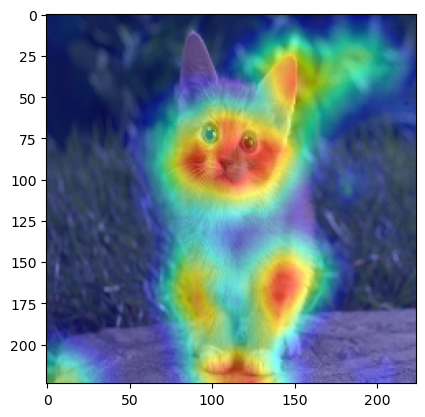

mask.png


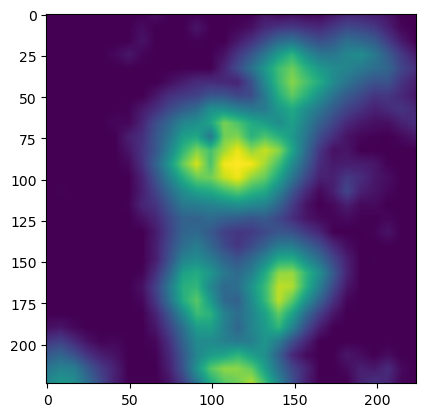

heatmap.png


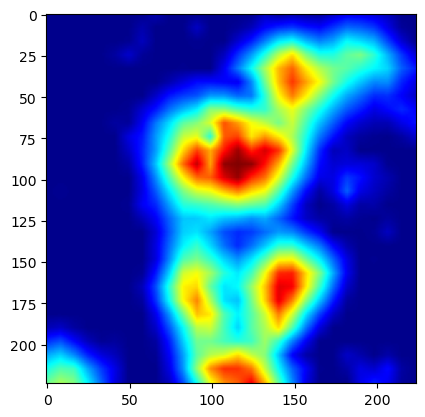

In [49]:
#import IPython.display 
import matplotlib.pyplot as plt
%matplotlib inline

for p in ['cam.png', 'mask.png', 'heatmap.png']:
    print(p)
    plt.imshow(plt.imread(p))
    plt.show()
#    IPython.display.Image(filename=p)
#IPython.display.Image(filename='heatmap.png')

In [46]:
import torchvision
from torchvision import transforms

# RGB 各チャンネルの平均と分散の定義。CNN 唯一の前処理
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

transform = torchvision.transforms.Compose([
    #torchvision.transforms.Resize(256), 
    torchvision.transforms.Resize((224,224)), 
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean, std)  # 標準化)
    ])


def print_class_names(img=None, 
                      model=model, 
                      n_best=5,
                      no_transform:bool=False,
                     ):
    
    if no_transform:
        inputs = img
    else:
        inputs = transform(img).unsqueeze_(0)
        
    model.eval()
    out = model(inputs)
    prob = torch.nn.functional.softmax(out[0], dim=0)  # 戻り値を softmax を使って確率に変換
    ids = np.argsort(- out.detach().numpy()[0])        # 認識した画像のクラス番号

    for i in range(n_best):
        print(f'{i+1:3d} {prob[ids[i]]:.3f}', end=" ")
        class_id = class_list[ids[i]]

        # class_id から wordnet の pos と offset を求める
        pos, offset = class_id[0], int(class_id[1:])

        # wordnet の項目を得る
        synset = wordnet.synset_from_pos_and_offset(pos,offset)  

        # wordnet に日本語があれば日本語化
        lang = 'jpn' if synset.lemmas(lang='jpn') else 'eng'

        # クラス名得る
        name = str(synset.lemmas(lang=lang)[0]).split('.')[-1].replace('\')','') 

        # クラス名，クラスid, クラスsynset の印字
        print(f'{name} ({ids[i]}:{class_id})')                   

#n_best = 10  # 上位 n_best 項目を表示する設定
#print_class_names(img=img_pil, n_best=n_best)

In [47]:
#model(img)

original_img = cv2.imread(img_fname, 1)
original_img = cv2.resize(original_img, (224, 224))
img = np.float32(original_img) / 255
blurred_img1 = cv2.GaussianBlur(img, (11, 11), 5)
blurred_img2 = np.float32(cv2.medianBlur(original_img, 11))/255
blurred_img_numpy = (blurred_img1 + blurred_img2) / 2
mask_init = np.ones((28, 28), dtype = np.float32)
    
# Convert to torch variables
_img = preprocess_image(img)
#plt.imshow(_img[0].detach().numpy().transpose(1,2,0).clip(0,1))
n_best = 10  # 上位 n_best 項目を表示する設定
print_class_names(img=_img, n_best=n_best, no_transform=True)
_img.size()

  1 0.401 キャンピングカー (285:n04065272)
  2 0.268 トラクタトラック (282:n04467665)
  3 0.156 レッカー (281:n04461696)
  4 0.032 水陸両用車 (263:n02704792)
  5 0.013 スクータ (259:n03791053)
  6 0.013 プルークボーゲン (277:n04252225)
  7 0.012 Lakeland_terrier (151:n02095570)
  8 0.010 消防自動車 (278:n03345487)
  9 0.006 アップライトピアノ (333:n04515003)
 10 0.006 護送車 (284:n03977966)


torch.Size([1, 3, 224, 224])